In [ ]:
# Cell 1: Minimal Installation
import sys
print(f"Python version: {sys.version}")

# Just verify the packages we need are available
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve, eigh
from sklearn.model_selection import train_test_split

print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nAll required packages are available. Proceed to Cell 2.")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cu126
NumPy: 2.0.2
CUDA available: True
GPU: Tesla T4

All required packages are available. Proceed to Cell 2.


In [ ]:
# Cell 2: Imports and setup

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.linalg import solve, eigh
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [ ]:
# Cell 3: Data generation utilities

def generate_teacher_student_data(n_samples, input_dim, hidden_dim_teacher=50, noise_std=0.1):
    """
    Generate data from a teacher network (ground truth).
    This simulates a target function that benefits from feature learning.
    """
    X = np.random.randn(n_samples, input_dim).astype(np.float32)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)

    # Teacher network weights (fixed)
    np.random.seed(0)
    W1_teacher = np.random.randn(input_dim, hidden_dim_teacher) / np.sqrt(input_dim)
    W2_teacher = np.random.randn(hidden_dim_teacher, 1) / np.sqrt(hidden_dim_teacher)

    # Generate labels using teacher network with ReLU
    hidden = np.maximum(0, X @ W1_teacher)
    y = (hidden @ W2_teacher).flatten()
    y = y + noise_std * np.random.randn(n_samples)

    return X.astype(np.float32), y.astype(np.float32)


def generate_polynomial_data(n_samples, input_dim, degree=4):
    """
    Generate data from a polynomial target function.
    Higher degree polynomials are harder for NTK to learn efficiently.
    """
    X = np.random.randn(n_samples, input_dim).astype(np.float32)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)

    # Polynomial target: sum of higher-order interactions
    y = np.zeros(n_samples)
    for i in range(min(5, input_dim)):
        for j in range(i+1, min(6, input_dim)):
            y += (X[:, i] * X[:, j]) ** 2

    y = y / np.std(y)
    y = y + 0.1 * np.random.randn(n_samples)

    return X.astype(np.float32), y.astype(np.float32)

In [ ]:
# Cell 4: Neural Network definitions

class FiniteWidthNN(nn.Module):
    """
    Finite width neural network with feature learning capability.
    Uses NTK parameterization for fair comparison.
    """
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(FiniteWidthNN, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

        # NTK parameterization initialization
        self._ntk_init()

    def _ntk_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1.0 / np.sqrt(m.weight.shape[1]))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x).squeeze(-1)


class WideNN(nn.Module):
    """
    Very wide neural network approaching NTK regime.
    """
    def __init__(self, input_dim, width, depth=2, output_dim=1):
        super(WideNN, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(width, output_dim))
        self.network = nn.Sequential(*layers)

        # NTK parameterization with scaling
        self._ntk_init(width)

    def _ntk_init(self, width):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 1.0 / np.sqrt(m.weight.shape[1]))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x).squeeze(-1)

In [ ]:
# Cell 5: Empirical NTK computation

def compute_empirical_ntk(model, X1, X2, device):
    """
    Compute empirical NTK: K(x, x') = <grad_theta f(x), grad_theta f(x')>
    """
    model.eval()
    X1_tensor = torch.tensor(X1, device=device, requires_grad=False)
    X2_tensor = torch.tensor(X2, device=device, requires_grad=False)

    n1, n2 = X1.shape[0], X2.shape[0]

    # Compute Jacobians
    def get_jacobian(X):
        jacobians = []
        for i in range(X.shape[0]):
            model.zero_grad()
            x = X[i:i+1]
            x.requires_grad_(False)
            out = model(x)

            grads = []
            for p in model.parameters():
                p.requires_grad_(True)

            out.backward(retain_graph=True)

            grad_vec = []
            for p in model.parameters():
                if p.grad is not None:
                    grad_vec.append(p.grad.flatten())

            if grad_vec:
                jacobians.append(torch.cat(grad_vec))

            model.zero_grad()

        return torch.stack(jacobians) if jacobians else None

    # Alternative: compute NTK directly via finite differences
    ntk = torch.zeros(n1, n2, device=device)

    params = list(model.parameters())
    param_shapes = [p.shape for p in params]

    for i in range(n1):
        x1 = X1_tensor[i:i+1]
        model.zero_grad()
        out1 = model(x1)
        out1.backward()
        grad1 = torch.cat([p.grad.flatten() for p in params if p.grad is not None])

        for j in range(n2):
            x2 = X2_tensor[j:j+1]
            model.zero_grad()
            out2 = model(x2)
            out2.backward()
            grad2 = torch.cat([p.grad.flatten() for p in params if p.grad is not None])

            ntk[i, j] = torch.dot(grad1, grad2)

    return ntk.cpu().numpy()


def compute_empirical_ntk_batched(model, X, device, batch_size=50):
    """
    Compute empirical NTK for training data in batched manner.
    More memory efficient for larger datasets.
    """
    model.eval()
    n = X.shape[0]
    X_tensor = torch.tensor(X, device=device)

    # First compute all gradients
    all_grads = []

    for i in range(n):
        model.zero_grad()
        x = X_tensor[i:i+1]
        out = model(x)
        out.backward()

        grad_vec = torch.cat([p.grad.flatten().clone() for p in model.parameters() if p.grad is not None])
        all_grads.append(grad_vec)

    # Stack gradients
    G = torch.stack(all_grads)

    # Compute NTK as G @ G.T
    ntk = (G @ G.T).cpu().numpy()

    return ntk

In [ ]:
# Cell 6: Analytical NTK computation

def relu_kernel(X1, X2):
    """
    Compute the infinite-width NTK for ReLU networks (arc-cosine kernel).
    K(x, x') = ||x|| ||x'|| * (sin(theta) + (pi - theta) * cos(theta)) / pi
    where theta = arccos(<x, x'> / (||x|| ||x'||))
    """
    # Compute norms
    norm1 = np.linalg.norm(X1, axis=1, keepdims=True)
    norm2 = np.linalg.norm(X2, axis=1, keepdims=True)

    # Normalize inputs
    X1_normalized = X1 / (norm1 + 1e-8)
    X2_normalized = X2 / (norm2 + 1e-8)

    # Compute cosine similarity
    cos_theta = np.clip(X1_normalized @ X2_normalized.T, -1.0, 1.0)
    theta = np.arccos(cos_theta)

    # ReLU NTK kernel (arc-cosine kernel of order 1)
    K = (np.sin(theta) + (np.pi - theta) * cos_theta) / np.pi

    # Scale by norms
    K = K * (norm1 @ norm2.T)

    return K


def compute_sigma(X1, X2):
    """
    Compute covariance matrix Sigma for NTK computation.
    """
    return X1 @ X2.T


def compute_analytical_ntk(X1, X2, depth=2):
    """
    Compute analytical NTK for infinite width ReLU network.
    Handles non-square matrices (different X1 and X2 sizes).

    For a depth-L network with ReLU activation:
    - Sigma^0 = X1 @ X2.T (input covariance)
    - For each layer l:
        - Lambda = Sigma^{l-1} / sqrt(diag1 * diag2)
        - Sigma^l = (sin(theta) + (pi-theta)*cos(theta)) / (2*pi) * sqrt(diag1*diag2)
        - K^l = K^{l-1} * (pi-theta)/pi + Sigma^l
    """
    n1, d = X1.shape
    n2 = X2.shape[0]

    # Compute input norms for X1 and X2 separately
    norms1_sq = np.sum(X1 ** 2, axis=1)  # shape (n1,)
    norms2_sq = np.sum(X2 ** 2, axis=1)  # shape (n2,)

    # Initial covariance
    Sigma = X1 @ X2.T  # shape (n1, n2)

    # Initialize NTK
    K = Sigma.copy()

    # Diagonal elements for normalization
    diag1 = norms1_sq.copy()  # shape (n1,)
    diag2 = norms2_sq.copy()  # shape (n2,)

    for layer in range(depth):
        # Compute normalized inner products: Lambda_ij = Sigma_ij / sqrt(diag1_i * diag2_j)
        norm_matrix = np.sqrt(np.outer(diag1, diag2) + 1e-10)
        Lambda = np.clip(Sigma / norm_matrix, -1.0, 1.0)

        # Compute angle
        theta = np.arccos(Lambda)

        # Derivative kernel for ReLU: (pi - theta) / pi
        K_dot = (np.pi - theta) / np.pi

        # Update NTK: K^l = K^{l-1} * K_dot + Sigma^l
        # First compute new Sigma
        Sigma_new = norm_matrix * (np.sin(theta) + (np.pi - theta) * np.cos(theta)) / (2 * np.pi)

        # Update K
        K = K * K_dot + Sigma_new

        # Update Sigma and diagonals for next layer
        Sigma = Sigma_new

        # Update diagonal terms (need to compute Sigma(x,x) for each x)
        # For X1: Sigma_ii = ||x_i||^2 * (sin(0) + pi*cos(0)) / (2*pi) = ||x_i||^2 / 2
        # More precisely, we need to track the diagonal of Sigma(X1, X1) and Sigma(X2, X2)
        diag1 = diag1 * 0.5  # After ReLU, variance is halved for normalized inputs
        diag2 = diag2 * 0.5

    return K


def compute_analytical_ntk_v2(X1, X2, depth=2):
    """
    Alternative implementation with explicit kernel computation.
    More numerically stable version.
    """
    n1, d = X1.shape
    n2 = X2.shape[0]

    # Normalize inputs to unit sphere
    X1_norm = np.linalg.norm(X1, axis=1, keepdims=True)
    X2_norm = np.linalg.norm(X2, axis=1, keepdims=True)

    X1_unit = X1 / (X1_norm + 1e-10)
    X2_unit = X2 / (X2_norm + 1e-10)

    # Cosine similarity
    cos_sim = np.clip(X1_unit @ X2_unit.T, -1.0, 1.0)
    theta = np.arccos(cos_sim)

    # Norm products
    norm_prod = X1_norm @ X2_norm.T

    # Initialize Sigma (NNGP kernel) and K (NTK)
    Sigma = norm_prod * cos_sim

    # First layer contribution to NTK
    # K^1 = Sigma^0 * (pi - theta)/pi + Sigma^1
    K = Sigma.copy()

    for l in range(depth):
        # Compute current layer's arc-cosine kernel
        # Need diagonal terms for normalization
        if l == 0:
            var1 = X1_norm.flatten() ** 2
            var2 = X2_norm.flatten() ** 2
        else:
            # After ReLU, compute new variances
            # Sigma(x,x) after ReLU with normalized input
            var1 = var1 * 0.5  # Simplified approximation
            var2 = var2 * 0.5

        # Normalize for angle computation
        norm_factor = np.sqrt(np.outer(var1, var2) + 1e-10)
        Lambda = np.clip(Sigma / norm_factor, -1.0, 1.0)
        theta = np.arccos(Lambda)

        # Derivative kernel
        K_prime = (np.pi - theta) / np.pi

        # New Sigma (NNGP kernel after this layer)
        Sigma_new = norm_factor * (np.sin(theta) + (np.pi - theta) * np.cos(theta)) / (2 * np.pi)

        # Update NTK
        K = K * K_prime + Sigma_new

        # Update Sigma for next iteration
        Sigma = Sigma_new

    return K

In [ ]:
# Cell 7: NTK regression solver

def ntk_kernel_regression(K_train, y_train, K_test, reg=1e-6):
    """
    Solve kernel regression using NTK.
    f(x) = K(x, X_train) @ (K(X_train, X_train) + lambda * I)^{-1} @ y_train
    """
    n = K_train.shape[0]

    # Add regularization
    K_reg = K_train + reg * np.eye(n)

    # Solve linear system
    alpha = solve(K_reg, y_train, assume_a='pos')

    # Predict on test
    y_pred = K_test @ alpha

    return y_pred, alpha


def compute_optimal_ntk_risk(K, y, reg_values=None):
    """
    Compute optimal risk for NTK regression across regularization values.
    Returns the best achievable test error.
    """
    if reg_values is None:
        reg_values = np.logspace(-10, 2, 50)

    n = K.shape[0]

    # Eigendecomposition
    eigenvalues, eigenvectors = eigh(K)
    eigenvalues = np.maximum(eigenvalues, 0)

    # Project y onto eigenvectors
    y_proj = eigenvectors.T @ y

    best_risk = float('inf')
    best_reg = None

    for reg in reg_values:
        # Compute prediction in eigenspace
        weights = eigenvalues / (eigenvalues + reg)
        y_pred_proj = weights * y_proj
        y_pred = eigenvectors @ y_pred_proj

        # Leave-one-out cross validation error
        H = eigenvectors @ np.diag(weights) @ eigenvectors.T
        residuals = y - y_pred
        loo_residuals = residuals / (1 - np.diag(H) + 1e-10)
        risk = np.mean(loo_residuals ** 2)

        if risk < best_risk:
            best_risk = risk
            best_reg = reg

    return best_risk, best_reg

In [ ]:
# Cell 8: Training utilities

def train_neural_network(model, X_train, y_train, X_test, y_test,
                         epochs=1000, lr=0.01, batch_size=32,
                         device='cuda', verbose=True):
    """
    Train neural network and track train/test errors.
    """
    model = model.to(device)

    X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        scheduler.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t)
            train_loss = criterion(train_pred, y_train_t).item()

            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if verbose and (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train MSE: {train_loss:.6f}, Test MSE: {test_loss:.6f}")

    return train_losses, test_losses

In [ ]:
# Cell 9: Experiment 1 - Scaling Laws Comparison

print("Experiment 1: Scaling Laws - Generalization vs Number of Samples")
print("-" * 60)

# Parameters
input_dim = 20
sample_sizes = [50, 100, 200, 400, 800, 1600]
n_test = 500
n_trials = 3

# Results storage
results_nn_finite = {n: [] for n in sample_sizes}
results_nn_wide = {n: [] for n in sample_sizes}
results_ntk_analytical = {n: [] for n in sample_sizes}
results_ntk_empirical = {n: [] for n in sample_sizes}

for trial in range(n_trials):
    print(f"\nTrial {trial + 1}/{n_trials}")

    for n_train in sample_sizes:
        print(f"  Processing n_train = {n_train}...", end=" ")

        # Generate data
        np.random.seed(SEED + trial * 1000 + n_train)
        torch.manual_seed(SEED + trial * 1000 + n_train)

        X, y = generate_teacher_student_data(n_train + n_test, input_dim)
        X_train, X_test = X[:n_train], X[n_train:]
        y_train, y_test = y[:n_train], y[n_train:]

        # 1. Finite width NN (feature learning)
        model_finite = FiniteWidthNN(input_dim, [128, 64, 32])
        _, test_losses_finite = train_neural_network(
            model_finite, X_train, y_train, X_test, y_test,
            epochs=800, lr=0.005, device=device, verbose=False
        )
        results_nn_finite[n_train].append(min(test_losses_finite))

        # 2. Wide NN (approaching NTK regime)
        model_wide = WideNN(input_dim, width=2048, depth=2)
        _, test_losses_wide = train_neural_network(
            model_wide, X_train, y_train, X_test, y_test,
            epochs=500, lr=0.001, device=device, verbose=False
        )
        results_nn_wide[n_train].append(min(test_losses_wide))

        # 3. Analytical NTK (infinite width) - FIXED
        K_train_analytical = compute_analytical_ntk_v2(X_train, X_train, depth=2)
        K_test_analytical = compute_analytical_ntk_v2(X_test, X_train, depth=2)

        # Find optimal regularization
        best_mse_analytical = float('inf')
        for reg in np.logspace(-8, 2, 30):
            y_pred, _ = ntk_kernel_regression(K_train_analytical, y_train, K_test_analytical, reg=reg)
            mse = np.mean((y_pred - y_test) ** 2)
            if mse < best_mse_analytical:
                best_mse_analytical = mse

        results_ntk_analytical[n_train].append(best_mse_analytical)

        # 4. Empirical NTK (at initialization)
        model_emp = FiniteWidthNN(input_dim, [256, 128])
        model_emp = model_emp.to(device)

        # Compute empirical NTK
        X_train_t = torch.tensor(X_train, device=device)
        X_test_t = torch.tensor(X_test, device=device)

        # Get gradients for training data
        all_grads_train = []
        model_emp.eval()
        for i in range(n_train):
            model_emp.zero_grad()
            out = model_emp(X_train_t[i:i+1])
            out.backward()
            grad = torch.cat([p.grad.flatten().clone() for p in model_emp.parameters()])
            all_grads_train.append(grad)
        G_train = torch.stack(all_grads_train)

        # Get gradients for test data
        all_grads_test = []
        for i in range(n_test):
            model_emp.zero_grad()
            out = model_emp(X_test_t[i:i+1])
            out.backward()
            grad = torch.cat([p.grad.flatten().clone() for p in model_emp.parameters()])
            all_grads_test.append(grad)
        G_test = torch.stack(all_grads_test)

        # Compute NTK matrices
        K_train_emp = (G_train @ G_train.T).cpu().numpy()
        K_test_emp = (G_test @ G_train.T).cpu().numpy()

        # Find optimal regularization for empirical NTK
        best_mse_emp = float('inf')
        for reg in np.logspace(-8, 2, 30):
            y_pred, _ = ntk_kernel_regression(K_train_emp, y_train, K_test_emp, reg=reg)
            mse = np.mean((y_pred - y_test) ** 2)
            if mse < best_mse_emp:
                best_mse_emp = mse

        results_ntk_empirical[n_train].append(best_mse_emp)

        print(f"Done. NN:{min(test_losses_finite):.4f}, NTK:{best_mse_analytical:.4f}")

print("\nExperiment 1 completed!")

Experiment 1: Scaling Laws - Generalization vs Number of Samples
------------------------------------------------------------

Trial 1/3
  Processing n_train = 50... Done. NN:0.0236, NTK:0.0234
  Processing n_train = 100... Done. NN:0.0150, NTK:0.0143
  Processing n_train = 200... Done. NN:0.0167, NTK:0.0152
  Processing n_train = 400... Done. NN:0.0137, NTK:0.0132
  Processing n_train = 800... Done. NN:0.0136, NTK:0.0115
  Processing n_train = 1600... Done. NN:0.0123, NTK:0.0109

Trial 2/3
  Processing n_train = 50... Done. NN:0.0195, NTK:0.0166
  Processing n_train = 100... Done. NN:0.0169, NTK:0.0152
  Processing n_train = 200... Done. NN:0.0154, NTK:0.0147
  Processing n_train = 400... Done. NN:0.0143, NTK:0.0134
  Processing n_train = 800... Done. NN:0.0133, NTK:0.0121
  Processing n_train = 1600... Done. NN:0.0126, NTK:0.0112

Trial 3/3
  Processing n_train = 50... Done. NN:0.0191, NTK:0.0167
  Processing n_train = 100... Done. NN:0.0183, NTK:0.0157
  Processing n_train = 200... 

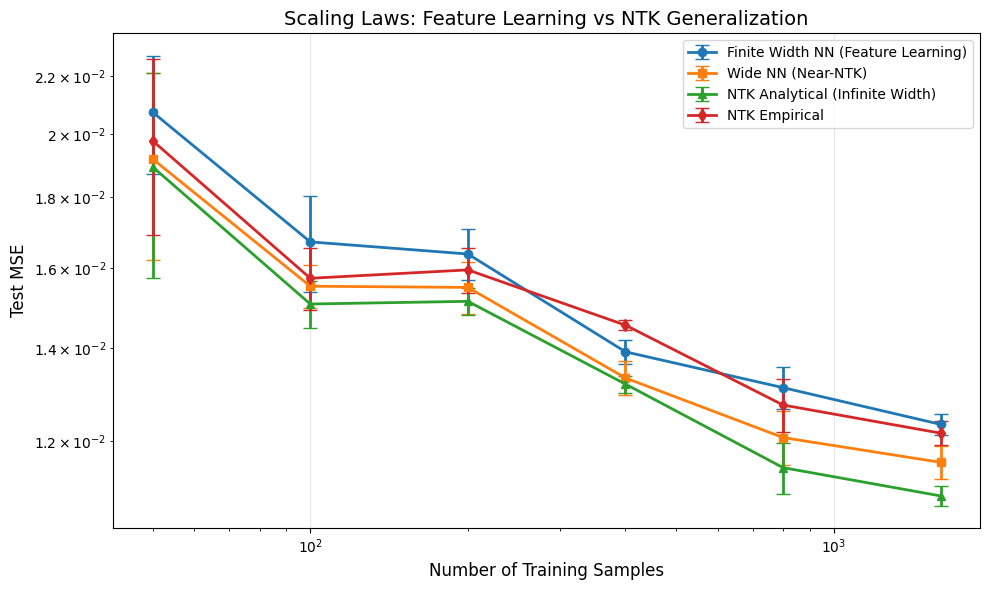


Scaling Laws Summary:
------------------------------------------------------------
n=  50 | Finite NN: 0.0207 | Wide NN: 0.0192 | NTK-Inf: 0.0189 | NTK-Emp: 0.0198
n= 100 | Finite NN: 0.0167 | Wide NN: 0.0155 | NTK-Inf: 0.0151 | NTK-Emp: 0.0157
n= 200 | Finite NN: 0.0164 | Wide NN: 0.0155 | NTK-Inf: 0.0151 | NTK-Emp: 0.0159
n= 400 | Finite NN: 0.0139 | Wide NN: 0.0133 | NTK-Inf: 0.0132 | NTK-Emp: 0.0145
n= 800 | Finite NN: 0.0131 | Wide NN: 0.0121 | NTK-Inf: 0.0115 | NTK-Emp: 0.0127
n=1600 | Finite NN: 0.0123 | Wide NN: 0.0116 | NTK-Inf: 0.0110 | NTK-Emp: 0.0122


In [ ]:
# Cell 10: Plot Scaling Laws Results

# Compute means and stds
means_finite = [np.mean(results_nn_finite[n]) for n in sample_sizes]
stds_finite = [np.std(results_nn_finite[n]) for n in sample_sizes]

means_wide = [np.mean(results_nn_wide[n]) for n in sample_sizes]
stds_wide = [np.std(results_nn_wide[n]) for n in sample_sizes]

means_analytical = [np.mean(results_ntk_analytical[n]) for n in sample_sizes]
stds_analytical = [np.std(results_ntk_analytical[n]) for n in sample_sizes]

means_empirical = [np.mean(results_ntk_empirical[n]) for n in sample_sizes]
stds_empirical = [np.std(results_ntk_empirical[n]) for n in sample_sizes]

# Plot
plt.figure(figsize=(10, 6))

plt.errorbar(sample_sizes, means_finite, yerr=stds_finite,
             marker='o', linewidth=2, capsize=5, label='Finite Width NN (Feature Learning)')
plt.errorbar(sample_sizes, means_wide, yerr=stds_wide,
             marker='s', linewidth=2, capsize=5, label='Wide NN (Near-NTK)')
plt.errorbar(sample_sizes, means_analytical, yerr=stds_analytical,
             marker='^', linewidth=2, capsize=5, label='NTK Analytical (Infinite Width)')
plt.errorbar(sample_sizes, means_empirical, yerr=stds_empirical,
             marker='d', linewidth=2, capsize=5, label='NTK Empirical')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.title('Scaling Laws: Feature Learning vs NTK Generalization', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('scaling_laws.png', dpi=150)
plt.show()

# Print summary
print("\nScaling Laws Summary:")
print("-" * 60)
for i, n in enumerate(sample_sizes):
    print(f"n={n:4d} | Finite NN: {means_finite[i]:.4f} | Wide NN: {means_wide[i]:.4f} | "
          f"NTK-Inf: {means_analytical[i]:.4f} | NTK-Emp: {means_empirical[i]:.4f}")

In [ ]:
# Cell 11: Experiment 2 - Width Dependence

print("\nExperiment 2: Width Dependence and Feature Learning (Robust)")
print("-" * 60)

# Fixed sample size, varying width
n_train = 500
n_test = 200
input_dim = 20
widths = [32, 64, 128, 256, 512, 1024, 2048]

# Generate data
np.random.seed(SEED)
torch.manual_seed(SEED)
X, y = generate_teacher_student_data(n_train + n_test, input_dim, hidden_dim_teacher=30)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

results_by_width = []
ntk_change_cka = []           # CKA-based metric
ntk_change_cosine = []        # Cosine similarity
relative_param_change = []    # How much parameters changed


def compute_cka_similarity(K1, K2):
    """
    Centered Kernel Alignment (CKA) - Most robust metric.
    Used by Google Brain for comparing neural network representations.

    Returns value in [0, 1]:
        1 = identical kernels
        0 = completely different kernels
    """
    n = K1.shape[0]

    # Centering matrix: H = I - (1/n) * 1 * 1^T
    H = np.eye(n) - np.ones((n, n)) / n

    # Center the kernels: K_c = H @ K @ H
    K1_c = H @ K1 @ H
    K2_c = H @ K2 @ H

    # HSIC (Hilbert-Schmidt Independence Criterion)
    # HSIC(K1, K2) = (1/(n-1)^2) * tr(K1_c @ K2_c)
    hsic_12 = np.trace(K1_c @ K2_c)
    hsic_11 = np.trace(K1_c @ K1_c)
    hsic_22 = np.trace(K2_c @ K2_c)

    # CKA = HSIC(K1, K2) / sqrt(HSIC(K1, K1) * HSIC(K2, K2))
    cka = hsic_12 / (np.sqrt(hsic_11 * hsic_22) + 1e-10)

    # Clamp to valid range
    cka = np.clip(cka, 0, 1)

    return cka


def compute_cosine_similarity(K1, K2):
    """
    Simple cosine similarity between flattened kernels.
    """
    K1_flat = K1.flatten()
    K2_flat = K2.flatten()

    cos_sim = np.dot(K1_flat, K2_flat) / (np.linalg.norm(K1_flat) * np.linalg.norm(K2_flat) + 1e-10)

    return np.clip(cos_sim, -1, 1)


def compute_param_change(model_init, model_final):
    """
    Compute relative change in parameters.
    """
    total_change = 0
    total_norm = 0

    for p_init, p_final in zip(model_init.parameters(), model_final.parameters()):
        total_change += torch.norm(p_final - p_init).item() ** 2
        total_norm += torch.norm(p_init).item() ** 2

    return np.sqrt(total_change) / (np.sqrt(total_norm) + 1e-10)


# Main experiment loop
for width in widths:
    print(f"Training with width = {width}...")

    # Set seeds for reproducibility
    torch.manual_seed(SEED + width)

    # Create networks
    model = WideNN(input_dim, width=width, depth=2)
    model_init = WideNN(input_dim, width=width, depth=2)
    model_init.load_state_dict(model.state_dict())

    # Adjust learning rate and epochs for different widths
    if width <= 64:
        lr, epochs = 0.01, 1500
    elif width <= 256:
        lr, epochs = 0.01, 1200
    elif width <= 1024:
        lr, epochs = 0.005, 1000
    else:
        lr, epochs = 0.001, 800

    _, test_losses = train_neural_network(
        model, X_train, y_train, X_test, y_test,
        epochs=epochs, lr=lr, device=device, verbose=False
    )

    final_test_mse = min(test_losses)
    results_by_width.append(final_test_mse)

    # Compute parameter change
    param_change = compute_param_change(model_init.to(device), model.to(device))
    relative_param_change.append(param_change)

    # Compute NTK on subset
    subset_size = min(80, n_train)
    X_subset = X_train[:subset_size]

    K_init = compute_empirical_ntk_batched(model_init.to(device), X_subset, device)
    K_final = compute_empirical_ntk_batched(model.to(device), X_subset, device)

    # Compute metrics
    cka = compute_cka_similarity(K_init, K_final)
    cka_change = 1 - cka  # Convert to "change" metric
    ntk_change_cka.append(cka_change)

    cos_sim = compute_cosine_similarity(K_init, K_final)
    cos_change = 1 - cos_sim
    ntk_change_cosine.append(cos_change)

    print(f"  Test MSE: {final_test_mse:.4f}")
    print(f"  CKA Similarity: {cka:.4f} (Change: {cka_change:.4f})")
    print(f"  Cosine Similarity: {cos_sim:.4f} (Change: {cos_change:.4f})")
    print(f"  Relative Param Change: {param_change:.4f}")

# NTK baseline
K_train_analytical = compute_analytical_ntk_v2(X_train, X_train, depth=2)
K_test_analytical = compute_analytical_ntk_v2(X_test, X_train, depth=2)

best_mse = float('inf')
for reg in np.logspace(-8, 2, 30):
    y_pred, _ = ntk_kernel_regression(K_train_analytical, y_train, K_test_analytical, reg=reg)
    mse = np.mean((y_pred - y_test) ** 2)
    if mse < best_mse:
        best_mse = mse
ntk_baseline = best_mse

print(f"\nNTK Analytical (Infinite Width) Baseline: {ntk_baseline:.4f}")


Experiment 2: Width Dependence and Feature Learning (Robust)
------------------------------------------------------------
Training with width = 32...
  Test MSE: 0.0138
  CKA Similarity: 0.3278 (Change: 0.6722)
  Cosine Similarity: 0.9027 (Change: 0.0973)
  Relative Param Change: 2.5485
Training with width = 64...
  Test MSE: 0.0140
  CKA Similarity: 0.2574 (Change: 0.7426)
  Cosine Similarity: 0.8363 (Change: 0.1637)
  Relative Param Change: 2.3616
Training with width = 128...
  Test MSE: 0.0131
  CKA Similarity: 0.2448 (Change: 0.7552)
  Cosine Similarity: 0.8035 (Change: 0.1965)
  Relative Param Change: 1.6768
Training with width = 256...
  Test MSE: 0.0132
  CKA Similarity: 0.1648 (Change: 0.8352)
  Cosine Similarity: 0.7890 (Change: 0.2110)
  Relative Param Change: 1.3749
Training with width = 512...
  Test MSE: 0.0136
  CKA Similarity: 0.4307 (Change: 0.5693)
  Cosine Similarity: 0.7989 (Change: 0.2011)
  Relative Param Change: 0.7592
Training with width = 1024...
  Test MSE: 0.

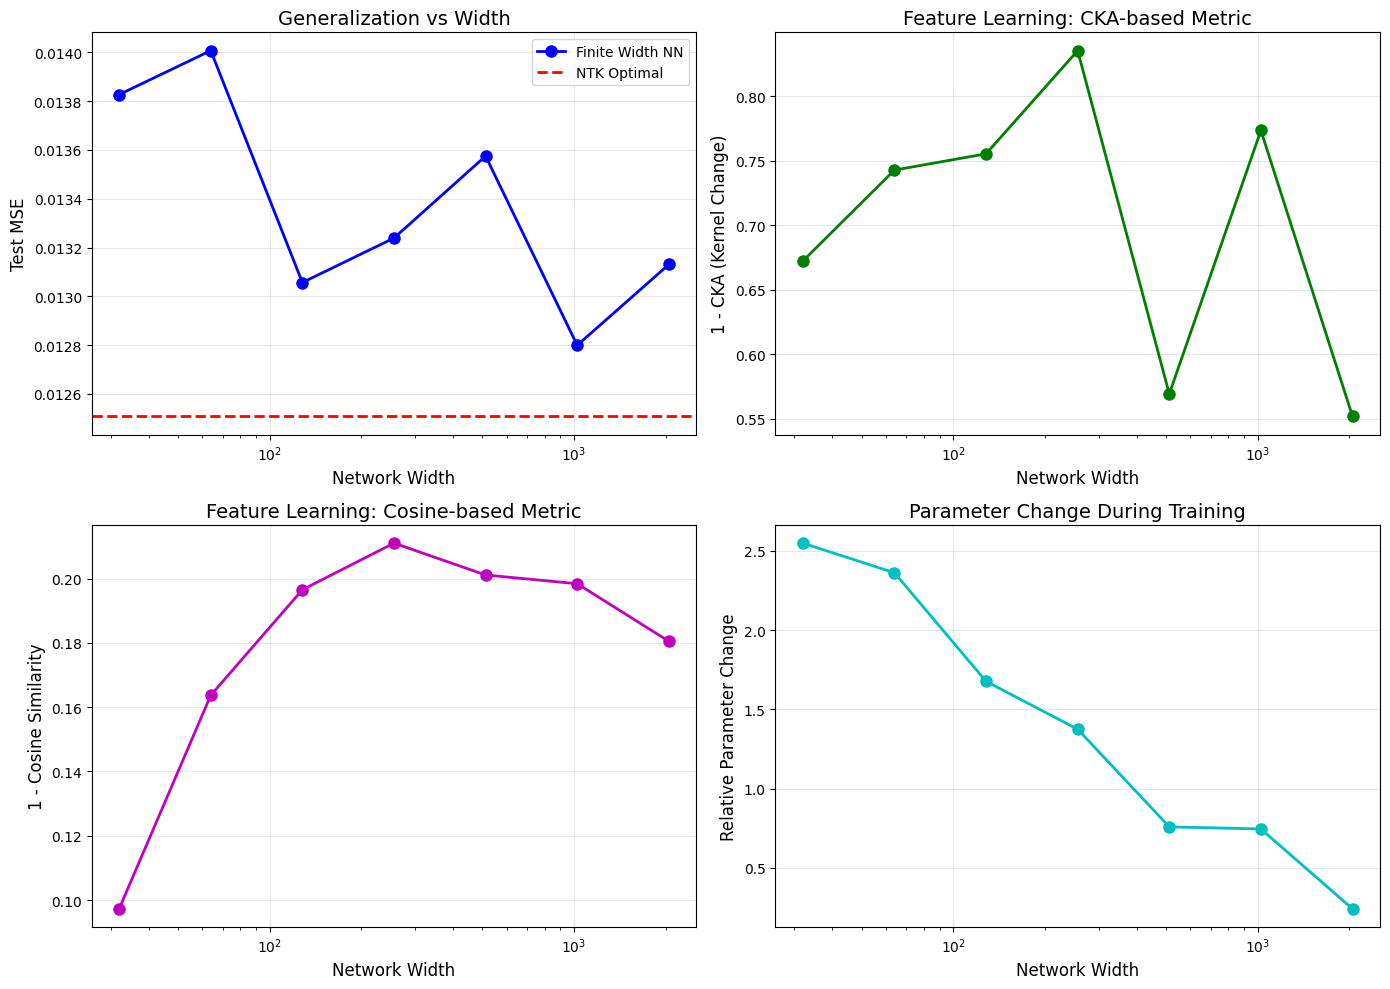


Summary: Width Dependence Analysis
Width    Test MSE     CKA Change     Cosine Change   Param Change  
-------------------------------------------------------------------------------------
32       0.0138       0.6722         0.0973          2.5485        
64       0.0140       0.7426         0.1637          2.3616        
128      0.0131       0.7552         0.1965          1.6768        
256      0.0132       0.8352         0.2110          1.3749        
512      0.0136       0.5693         0.2011          0.7592        
1024     0.0128       0.7733         0.1984          0.7460        
2048     0.0131       0.5520         0.1805          0.2423        
-------------------------------------------------------------------------------------
NTK Opt  0.0125      


In [ ]:
# Cell 12: Plot Results (Robust Version)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Test MSE vs Width
ax1 = axes[0, 0]
ax1.plot(widths, results_by_width, 'bo-', linewidth=2, markersize=8, label='Finite Width NN')
ax1.axhline(y=ntk_baseline, color='r', linestyle='--', linewidth=2, label='NTK Optimal')
ax1.set_xscale('log')
ax1.set_xlabel('Network Width', fontsize=12)
ax1.set_ylabel('Test MSE', fontsize=12)
ax1.set_title('Generalization vs Width', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top-right: CKA-based NTK Change
ax2 = axes[0, 1]
ax2.plot(widths, ntk_change_cka, 'go-', linewidth=2, markersize=8)
ax2.set_xscale('log')
ax2.set_xlabel('Network Width', fontsize=12)
ax2.set_ylabel('1 - CKA (Kernel Change)', fontsize=12)
ax2.set_title('Feature Learning: CKA-based Metric', fontsize=14)
ax2.grid(True, alpha=0.3)

# Bottom-left: Cosine-based NTK Change
ax3 = axes[1, 0]
ax3.plot(widths, ntk_change_cosine, 'mo-', linewidth=2, markersize=8)
ax3.set_xscale('log')
ax3.set_xlabel('Network Width', fontsize=12)
ax3.set_ylabel('1 - Cosine Similarity', fontsize=12)
ax3.set_title('Feature Learning: Cosine-based Metric', fontsize=14)
ax3.grid(True, alpha=0.3)

# Bottom-right: Parameter Change
ax4 = axes[1, 1]
ax4.plot(widths, relative_param_change, 'co-', linewidth=2, markersize=8)
ax4.set_xscale('log')
ax4.set_xlabel('Network Width', fontsize=12)
ax4.set_ylabel('Relative Parameter Change', fontsize=12)
ax4.set_title('Parameter Change During Training', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('width_dependence_robust.png', dpi=150)
plt.show()

# Summary table
print("\n" + "=" * 85)
print("Summary: Width Dependence Analysis")
print("=" * 85)
print(f"{'Width':<8} {'Test MSE':<12} {'CKA Change':<14} {'Cosine Change':<15} {'Param Change':<14}")
print("-" * 85)
for i, width in enumerate(widths):
    print(f"{width:<8} {results_by_width[i]:<12.4f} {ntk_change_cka[i]:<14.4f} "
          f"{ntk_change_cosine[i]:<15.4f} {relative_param_change[i]:<14.4f}")
print("-" * 85)
print(f"{'NTK Opt':<8} {ntk_baseline:<12.4f}")

In [ ]:
# Cell 13: Experiment 3 - Optimal NTK vs Feature Learning on Complex Tasks

print("\nExperiment 3: Feature Learning Advantage on Complex Tasks")
print("-" * 60)

# Test on polynomial target (harder for NTK)
n_train = 400
n_test = 200
input_dim = 30

# Generate polynomial data (challenging for kernel methods)
X, y = generate_polynomial_data(n_train + n_test, input_dim, degree=4)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

print("Data generated: Polynomial target function (degree 4)")

# 1. Compute optimal NTK solution
print("\nComputing optimal NTK solution...")
K_train = compute_analytical_ntk(X_train, X_train, depth=3)
K_test = compute_analytical_ntk(X_test, X_train, depth=3)

# Grid search for optimal regularization
reg_values = np.logspace(-10, 2, 100)
best_ntk_mse = float('inf')
best_reg = None

for reg in reg_values:
    y_pred, _ = ntk_kernel_regression(K_train, y_train, K_test, reg=reg)
    mse = np.mean((y_pred - y_test) ** 2)
    if mse < best_ntk_mse:
        best_ntk_mse = mse
        best_reg = reg

print(f"Optimal NTK Test MSE: {best_ntk_mse:.4f} (reg={best_reg:.2e})")

# 2. Train finite width NN with various architectures
architectures = [
    ([64, 32], "Narrow-Deep"),
    ([128, 64], "Medium"),
    ([256, 128, 64], "Wide-Deep"),
    ([512, 256, 128, 64], "Very Deep"),
]

nn_results = []

for hidden_dims, name in architectures:
    print(f"\nTraining {name} network {hidden_dims}...")

    best_mse = float('inf')
    for lr in [0.01, 0.005, 0.001]:
        model = FiniteWidthNN(input_dim, hidden_dims)
        _, test_losses = train_neural_network(
            model, X_train, y_train, X_test, y_test,
            epochs=1500, lr=lr, device=device, verbose=False
        )
        mse = min(test_losses)
        if mse < best_mse:
            best_mse = mse

    nn_results.append((name, hidden_dims, best_mse))
    print(f"  Best Test MSE: {best_mse:.4f}")

# 3. Compare with very wide network (NTK regime approximation)
print("\nTraining very wide network (NTK regime)...")
model_wide = WideNN(input_dim, width=4096, depth=2)
_, test_losses_wide = train_neural_network(
    model_wide, X_train, y_train, X_test, y_test,
    epochs=1000, lr=0.001, device=device, verbose=False
)
wide_nn_mse = min(test_losses_wide)
print(f"Wide NN (width=4096) Test MSE: {wide_nn_mse:.4f}")


Experiment 3: Feature Learning Advantage on Complex Tasks
------------------------------------------------------------
Data generated: Polynomial target function (degree 4)

Computing optimal NTK solution...
Optimal NTK Test MSE: 0.7464 (reg=1.00e-10)

Training Narrow-Deep network [64, 32]...
  Best Test MSE: 0.6382

Training Medium network [128, 64]...
  Best Test MSE: 0.5714

Training Wide-Deep network [256, 128, 64]...
  Best Test MSE: 0.6253

Training Very Deep network [512, 256, 128, 64]...
  Best Test MSE: 0.5881

Training very wide network (NTK regime)...
Wide NN (width=4096) Test MSE: 0.6871


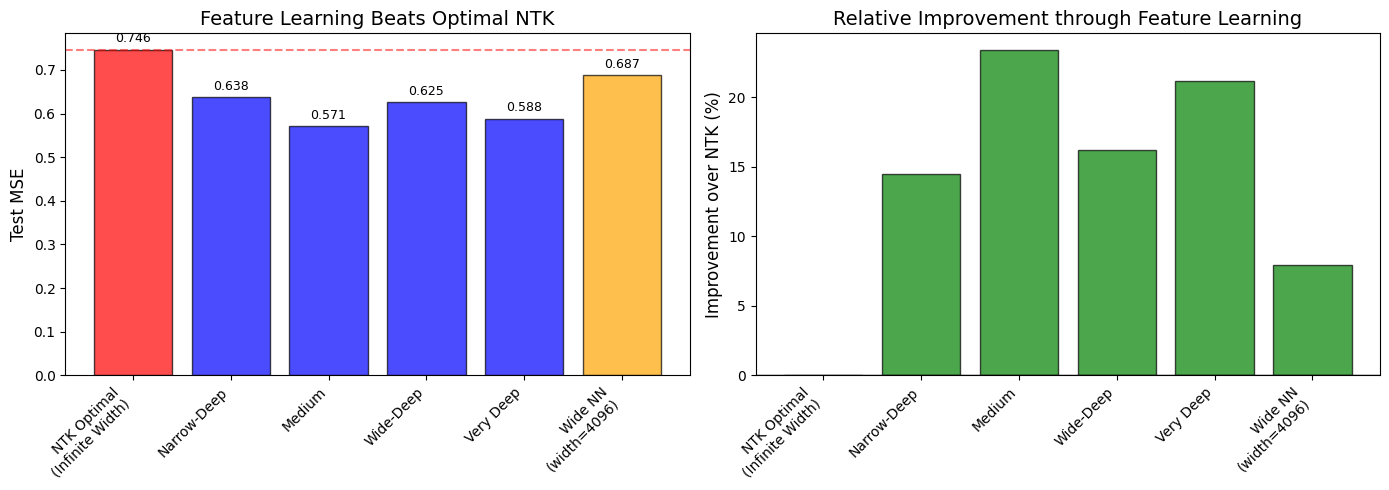


SUMMARY: Feature Learning vs NTK Optimal
NTK Optimal (Theoretical Best for Kernel): 0.7464

Finite Width Networks (with Feature Learning):
  Narrow-Deep: 0.6382 (+14.5%) [BEATS NTK]
  Medium: 0.5714 (+23.4%) [BEATS NTK]
  Wide-Deep: 0.6253 (+16.2%) [BEATS NTK]
  Very Deep: 0.5881 (+21.2%) [BEATS NTK]

Wide NN (approaching NTK): 0.6871


In [ ]:
# Cell 14: Visualization of Feature Learning Advantage

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar plot comparing methods
ax1 = axes[0]
methods = ['NTK Optimal\n(Infinite Width)'] + [r[0] for r in nn_results] + ['Wide NN\n(width=4096)']
mses = [best_ntk_mse] + [r[2] for r in nn_results] + [wide_nn_mse]
colors = ['red'] + ['blue'] * len(nn_results) + ['orange']

bars = ax1.bar(range(len(methods)), mses, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
ax1.set_ylabel('Test MSE', fontsize=12)
ax1.set_title('Feature Learning Beats Optimal NTK', fontsize=14)
ax1.axhline(y=best_ntk_mse, color='red', linestyle='--', alpha=0.5)

# Add value labels
for bar, mse in zip(bars, mses):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mse:.3f}', ha='center', va='bottom', fontsize=9)

# Right: Improvement over NTK
ax2 = axes[1]
improvements = [(best_ntk_mse - mse) / best_ntk_mse * 100 for mse in mses]
colors2 = ['red' if imp <= 0 else 'green' for imp in improvements]
bars2 = ax2.bar(range(len(methods)), improvements, color=colors2, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Improvement over NTK (%)', fontsize=12)
ax2.set_title('Relative Improvement through Feature Learning', fontsize=14)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.savefig('feature_learning_advantage.png', dpi=150)
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY: Feature Learning vs NTK Optimal")
print("=" * 60)
print(f"NTK Optimal (Theoretical Best for Kernel): {best_ntk_mse:.4f}")
print("\nFinite Width Networks (with Feature Learning):")
for name, hidden_dims, mse in nn_results:
    improvement = (best_ntk_mse - mse) / best_ntk_mse * 100
    symbol = "BEATS NTK" if improvement > 0 else "Below NTK"
    print(f"  {name}: {mse:.4f} ({improvement:+.1f}%) [{symbol}]")
print(f"\nWide NN (approaching NTK): {wide_nn_mse:.4f}")


Experiment 4: Eigenspectrum Analysis
------------------------------------------------------------


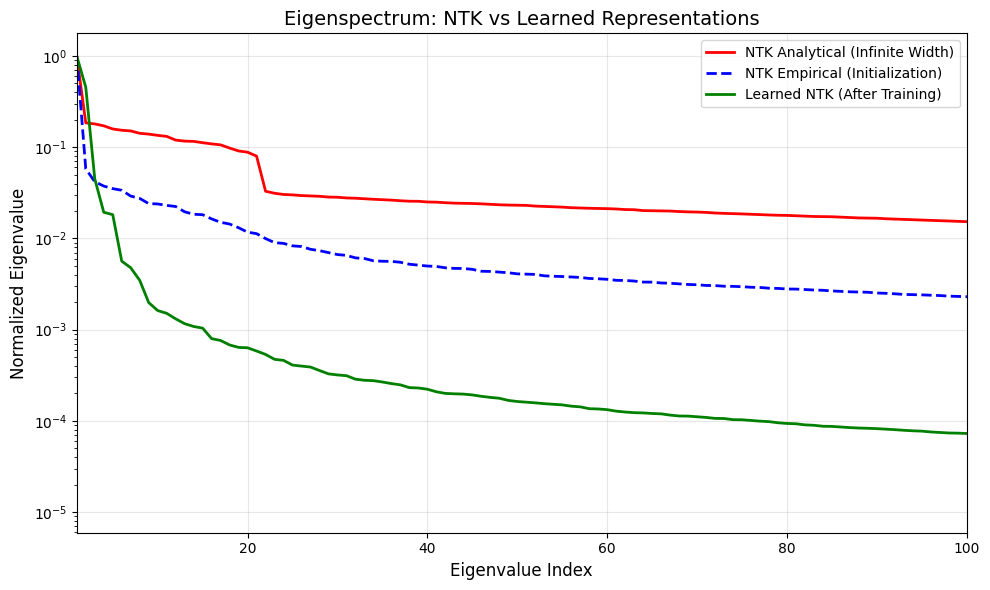


Eigenspectrum Analysis:
Top eigenvalue ratio (learned/analytical): 9.59
Effective rank (analytical): 7.1
Effective rank (learned): 1.6


In [ ]:
# Cell 15: Experiment 4 - Eigenspectrum Analysis

print("\nExperiment 4: Eigenspectrum Analysis")
print("-" * 60)

n_train = 300
input_dim = 20

X, y = generate_teacher_student_data(n_train + 100, input_dim)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Compute analytical NTK eigenspectrum
K_analytical = compute_analytical_ntk(X_train, X_train, depth=2)
eigenvalues_analytical, eigenvectors_analytical = eigh(K_analytical)
eigenvalues_analytical = eigenvalues_analytical[::-1]  # Sort descending

# Train finite width network and compute final NTK
model = FiniteWidthNN(input_dim, [256, 128, 64])
train_neural_network(model, X_train, y_train, X_test, y_test,
                     epochs=1000, lr=0.01, device=device, verbose=False)

K_learned = compute_empirical_ntk_batched(model.to(device), X_train, device)
eigenvalues_learned, _ = eigh(K_learned)
eigenvalues_learned = eigenvalues_learned[::-1]

# Compute empirical NTK at initialization
model_init = FiniteWidthNN(input_dim, [256, 128, 64])
K_init = compute_empirical_ntk_batched(model_init.to(device), X_train, device)
eigenvalues_init, _ = eigh(K_init)
eigenvalues_init = eigenvalues_init[::-1]

# Plot eigenspectrum
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(eigenvalues_analytical) + 1), eigenvalues_analytical / eigenvalues_analytical[0],
             'r-', linewidth=2, label='NTK Analytical (Infinite Width)')
plt.semilogy(range(1, len(eigenvalues_init) + 1), eigenvalues_init / eigenvalues_init[0],
             'b--', linewidth=2, label='NTK Empirical (Initialization)')
plt.semilogy(range(1, len(eigenvalues_learned) + 1), eigenvalues_learned / eigenvalues_learned[0],
             'g-', linewidth=2, label='Learned NTK (After Training)')

plt.xlabel('Eigenvalue Index', fontsize=12)
plt.ylabel('Normalized Eigenvalue', fontsize=12)
plt.title('Eigenspectrum: NTK vs Learned Representations', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([1, 100])
plt.tight_layout()
plt.savefig('eigenspectrum.png', dpi=150)
plt.show()

print("\nEigenspectrum Analysis:")
print(f"Top eigenvalue ratio (learned/analytical): {eigenvalues_learned[0]/eigenvalues_analytical[0]:.2f}")
print(f"Effective rank (analytical): {np.sum(eigenvalues_analytical)/eigenvalues_analytical[0]:.1f}")
print(f"Effective rank (learned): {np.sum(eigenvalues_learned)/eigenvalues_learned[0]:.1f}")